In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from matplotlib import cm
%matplotlib inline

In [2]:
"""
* Initialize actions, set player and dealer policies
"""
actions = {'hit' : 1, 'stick' : 0}
rewards = {'win' : 1, 'lose' : -1, 'draw' : 0}
policy_player = np.ones(22, dtype=int)
policy_player[20] = actions['stick']
policy_player[21] = actions['stick']

policy_dealer = np.ones(22, dtype=int)
for i in range(17, 22, 1):
    policy_dealer[i] = actions['stick']

In [3]:
"""
* Get a random card. All face cards values are changed to 10
"""
def get_card():
    card = randint(2, 14)
    if card == 14:
        return 11
    else:
        return min(10, card)
    
"""
* Initialize user state
"""
def init_user():
    user_card_1 = 0
    user_card_2 = 0
    user_sum = 0
    user_usable_ace_rcvd = False
    
    user_card_1 = get_card()
    if user_card_1 == 11:
        user_usable_ace_rcvd = True
    user_card_2 = get_card()
    if user_card_2 == 11:
        if user_usable_ace_rcvd:
            user_card_2 = 1
        else:
            user_usable_ace_rcvd = True
    
    user_sum += (user_card_1 + user_card_2)
    
    return (user_card_1, user_card_2, user_sum, int(user_usable_ace_rcvd))

In [4]:
def generate_episode():

    _, __, player_sum, player_usable_ace = init_user()
    player_episode = []
    
    dealer_card_1, _, dealer_sum, dealer_usable_ace = init_user()
    
    # Keep drawing a card till the player score crosses 12
    while player_sum < 12:
        card = get_card()
        
        if card == 11:
            if player_sum + card > 21:
                card = 1
            else:
                player_usable_ace += 1
        
        player_sum += card
        
    player_episode.append([player_sum, dealer_card_1, player_usable_ace > 0])
    
    # Check for draw or player win with natural
    if player_sum == 21:
        if dealer_sum == 21:
            return player_episode, 0
        else:
            return player_episode, 1
    
    # Keep playing with player according to policy
    while True:
        action = policy_player[player_sum]
        if action == actions['stick']:
            break
            
        card = get_card()
        if card == 11:
            player_usable_ace += 1
        player_sum += card
        
        # Since its an unlimited deck, the used may have multiple aces
        while player_sum > 21 and player_usable_ace:
            player_sum -= 10
            player_usable_ace -= 1
        
        if player_sum > 21:
            return player_episode, -1
        
        player_episode.append([player_sum, dealer_card_1, player_usable_ace > 0])
       
    # Dealer plays according to dealer policy
    while True:
        action = policy_dealer[dealer_sum]
        if action == actions['stick']:
            break
            
        card = get_card()
        if card == 11:
            dealer_usable_ace += 1
        dealer_sum += card
        
        while dealer_sum > 21 and dealer_usable_ace:
            dealer_sum -= 10
            dealer_usable_ace -= 1
        
        if dealer_sum > 21:
            return player_episode, 1
        
    if player_sum > dealer_sum:
        return player_episode, 1
    elif player_sum == dealer_sum:
        return player_episode, 0
    else:
        return player_episode, -1
        

In [5]:
def monte_carlo(num_episodes, first_visit=False):
    usable_ace_state_count = np.zeros((10, 10))
    usable_ace_state_value = np.zeros((10, 10))
    
    no_usable_ace_state_count = np.zeros((10, 10))
    no_usable_ace_state_value = np.zeros((10, 10))
    
    for i in range(1, num_episodes+1):
        player_episode, reward = generate_episode()
        for (player_sum, dealer_card, usable_ace) in player_episode:
            first_visit_check = np.zeros((2, 10, 10))
            if usable_ace:
                if dealer_card == 11:
                    dealer_card = 1
                # Check whether it first or every visit monte carlo
                if first_visit and first_visit_check[0, player_sum-12, dealer_card-1] == 1:
                    continue
                first_visit_check[0, player_sum-12, dealer_card-1] = 1
                
                # Update average value
                usable_ace_state_count[player_sum-12, dealer_card-1] += 1
                usable_ace_state_value[player_sum-12, dealer_card-1] = \
                    usable_ace_state_value[player_sum-12, dealer_card-1] + \
                    (1/usable_ace_state_count[player_sum-12, dealer_card-1]) * \
                    (reward - usable_ace_state_value[player_sum-12, dealer_card-1])
            else:
                if dealer_card == 11:
                    dealer_card = 1
                if first_visit and first_visit_check[1, player_sum-12, dealer_card-1] == 1:
                    continue
                first_visit_check[1, player_sum-12, dealer_card-1] = 1
                no_usable_ace_state_count[player_sum-12, dealer_card-1] += 1
                no_usable_ace_state_value[player_sum-12, dealer_card-1] = \
                    no_usable_ace_state_value[player_sum-12, dealer_card-1] + \
                    (1/no_usable_ace_state_count[player_sum-12, dealer_card-1]) * \
                    (reward - no_usable_ace_state_value[player_sum-12, dealer_card-1])
    return usable_ace_state_value, no_usable_ace_state_value    

# Plotting reference - https://matplotlib.org/3.1.0/gallery/mplot3d/surface3d.html

def plot_5_1():
    states_usable_ace_1, states_no_usable_ace_1 = monte_carlo(10000, first_visit=True)
    states_usable_ace_2, states_no_usable_ace_2 = monte_carlo(500000, first_visit=True)
    
    cplots = [states_usable_ace_1, states_no_usable_ace_1, states_usable_ace_2, states_no_usable_ace_2]
    titles = ['Usable Ace. After 10000 episodes', 'No Usable Ace. After 10000 episodes', 'Usable Ace. After 500000 episodes', 'No Usable Ace. After 500000 episodes']
    
    for cplot, title in zip(cplots, titles):
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        X = np.arange(1, 11)
        Y = np.arange(12, 22)
        X, Y = np.meshgrid(X, Y)

        Z = cplot

        surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
        ax.set_zlim(-1, 1)
        ax.set_xlim(1, 10)
        ax.set_ylim(12, 21)
        ax.set_xlabel('Dealer Card')
        ax.set_ylabel('Player Score')
        ax.set_zlabel('State-Value Function')
        
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
        fig.colorbar(surf, shrink=0.5, aspect=5)
        plt.title(title)
        plt.show()

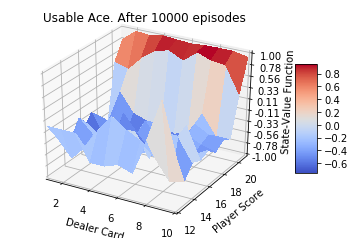

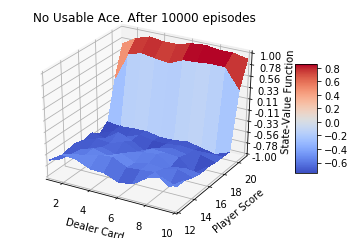

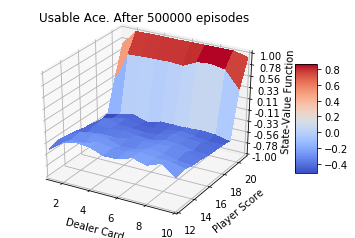

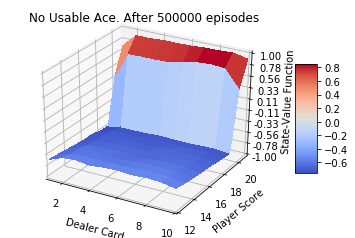

In [6]:
plot_5_1()